In [521]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier,RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve, auc
pd.set_option('display.max_columns',None)

In [522]:
df = pd.read_csv('survey.csv')

In [523]:
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [524]:
df.shape

(1259, 27)

In [525]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

In [526]:
df.isnull().sum()

,0
Timestamp,0
Age,0
Gender,0
Country,0
state,515
self_employed,18
family_history,0
treatment,0
work_interfere,264
no_employees,0


In [527]:
df.drop(columns=['Timestamp','comments'],inplace=True)

In [528]:
df['state'] = df['state'].fillna(df['state'].mode()[0])
df['work_interfere'] = df['work_interfere'].fillna(df['work_interfere'].mode()[0])

In [529]:
for col in df.columns:
    print(f"Unique values in column '{col}': {df[col].unique()}")
    print("-" * 40)

Unique values in column 'Age': [         37          44          32          31          33          35
          39          42          23          29          36          27
          46          41          34          30          40          38
          50          24          18          28          26          22
          19          25          45          21         -29          43
          56          60          54         329          55 99999999999
          48          20          57          58          47          62
          51          65          49       -1726           5          53
          61           8          11          -1          72]
----------------------------------------
Unique values in column 'Gender': ['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' 'f' 'Mal'
 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake' 'woman' 'Make' 'Nah'
 'All' 'Enby' 'fluid' 'Gende

In [530]:
def clean_gender(gender):
    if isinstance(gender, str):
        gender = gender.lower()
        if 'm' in gender:
            return 'male'
        elif 'f' in gender:
            return 'female'
        else:
            return 'other'
    else:
        return 'other'

df['Gender'] = df['Gender'].apply(clean_gender)

In [531]:
df['Gender'].unique()

array(['male', 'female', 'other'], dtype=object)

In [532]:
df = df[df['self_employed'].notna()]
print(df['self_employed'].unique())

['Yes' 'No']


In [533]:
def categorize_employees(x):
    if x == '1-5':
        return 1
    elif x == '6-25':
        return 2
    elif x == '26-100':
        return 3
    elif x == '100-500':
        return 4
    elif x == '500-1000':
        return 5
    elif x == 'More than 1000':
        return 6
    else:
        return 0 # Handle any other values as needed

# Apply the function to the 'no_employees' column
df['no_employees'] = df['no_employees'].apply(categorize_employees)

<ipython-input-533-4775a690944a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no_employees'] = df['no_employees'].apply(categorize_employees)


In [534]:
df = df[(df['Age'] <= 80) & (df['Age'] > 0) & (df['Age'] >= 20)]

In [535]:
df.head()

,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
18,46,male,United States,MD,Yes,Yes,No,Sometimes,1,Yes,Yes,Yes,Not sure,Yes,Don't know,Yes,Very easy,No,No,Yes,Yes,No,Yes,Yes,Yes
19,36,male,France,CA,Yes,Yes,No,Sometimes,2,Yes,Yes,No,No,Yes,No,Yes,Somewhat easy,No,No,Some of them,Some of them,Maybe,Maybe,Don't know,No
20,29,male,United States,NY,No,Yes,Yes,Sometimes,4,No,Yes,Yes,Yes,No,No,No,Somewhat difficult,Maybe,No,Some of them,Some of them,No,No,No,No
21,31,male,United States,NC,Yes,No,No,Never,1,Yes,Yes,No,No,No,No,Yes,Somewhat difficult,No,No,Some of them,Some of them,No,Maybe,Yes,No
22,46,male,United States,MA,No,No,Yes,Often,3,Yes,Yes,Yes,Yes,No,No,Don't know,Don't know,Maybe,No,Some of them,Yes,No,Maybe,No,No


In [536]:
le = LabelEncoder()

for col in df.columns:
    if col not in ['Age', 'no_employees']:
        df[col] = le.fit_transform(df[col])

In [537]:
df.head()

,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
18,46,1,43,16,1,1,0,3,1,1,1,2,1,2,0,2,4,1,1,2,2,1,2,2,1
19,36,1,14,2,1,1,0,3,2,1,1,1,0,2,1,2,2,1,1,1,1,0,0,0,0
20,29,1,43,28,0,1,1,3,4,0,1,2,2,1,1,1,1,0,1,1,1,1,1,1,0
21,31,1,43,22,1,0,0,0,1,1,1,1,0,1,1,2,1,1,1,1,1,1,0,2,0
22,46,1,43,15,0,0,1,1,3,1,1,2,2,1,1,0,0,0,1,1,2,1,0,1,0


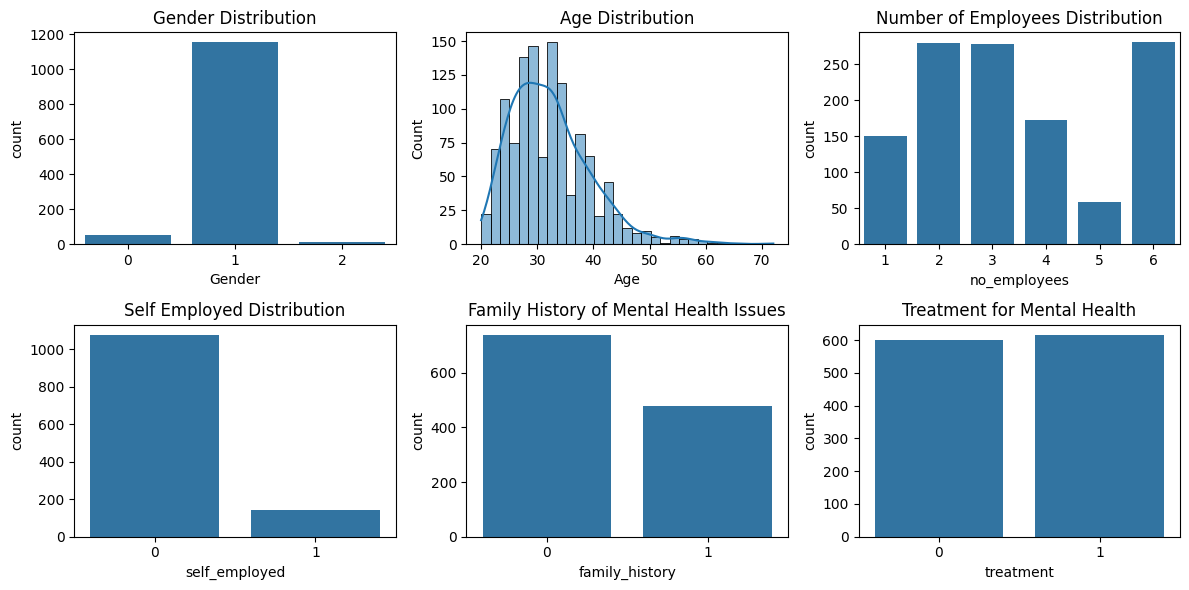

In [538]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
sns.countplot(x='Gender', data=df)
plt.title('Gender Distribution')

plt.subplot(2, 3, 2)
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')

plt.subplot(2, 3, 3)
sns.countplot(x='no_employees', data=df)
plt.title('Number of Employees Distribution')

plt.subplot(2, 3, 4)
sns.countplot(x='self_employed', data=df)
plt.title('Self Employed Distribution')

plt.subplot(2, 3, 5)
sns.countplot(x='family_history', data=df)
plt.title('Family History of Mental Health Issues')

plt.subplot(2, 3, 6)
sns.countplot(x='treatment', data=df)
plt.title('Treatment for Mental Health')

plt.tight_layout()
plt.show()

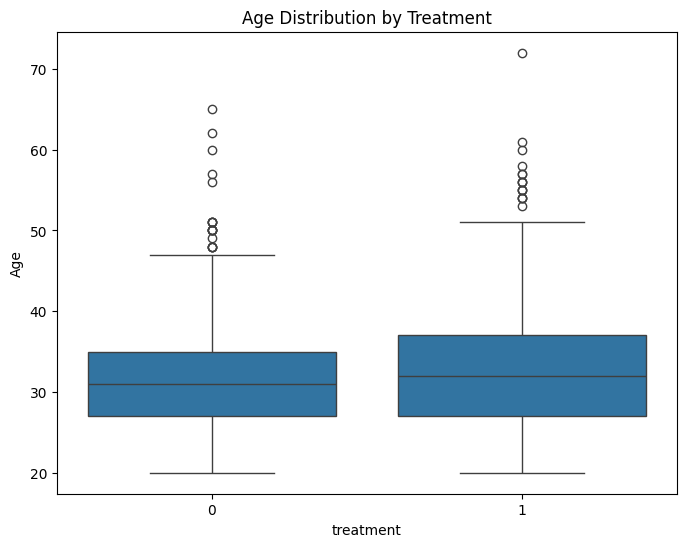

In [539]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='treatment', y='Age', data=df)
plt.title('Age Distribution by Treatment')
plt.show()

In [540]:
def remove_outliers(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    return group[~((group < (Q1 - 1.5 * IQR)) | (group > (Q3 + 1.5 * IQR)))]

# Apply the function for each treatment group
filtered_df = df.groupby('treatment')['Age'].apply(remove_outliers).reset_index()

print(filtered_df)

      treatment  level_1  Age
0             0       18   46
1             0       19   36
2             0       21   31
3             0       26   33
4             0       29   37
...         ...      ...  ...
1177          1     1252   29
1178          1     1254   26
1179          1     1255   32
1180          1     1256   34
1181          1     1258   25

[1182 rows x 3 columns]


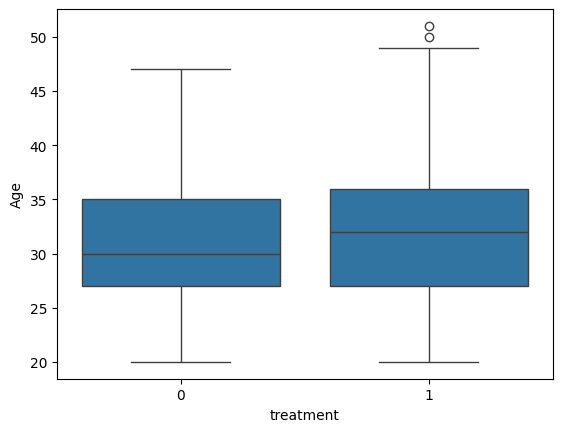

In [541]:
sns.boxplot(x='treatment', y='Age', data=filtered_df)
plt.show()

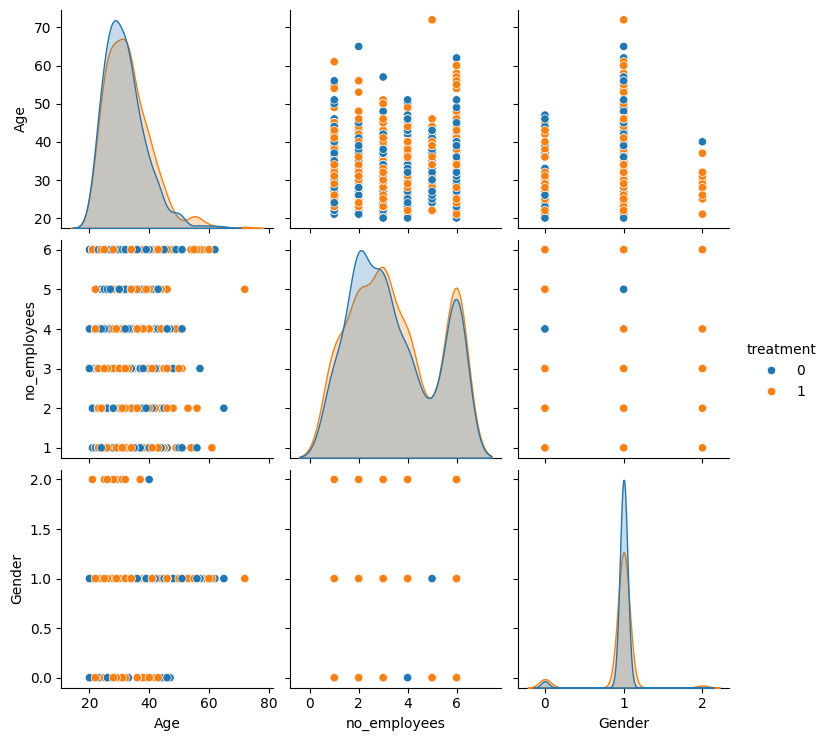

In [542]:
sns.pairplot(df[['Age', 'no_employees', 'treatment', 'Gender']], hue='treatment')
plt.show()

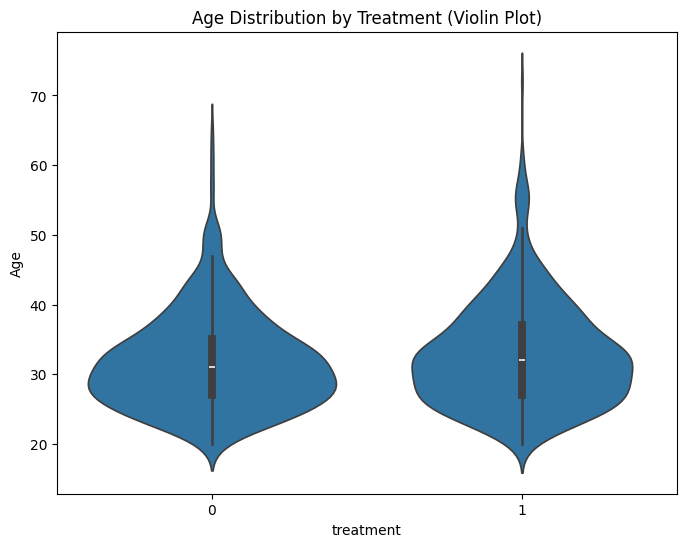

In [543]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='treatment', y='Age', data=df)
plt.title('Age Distribution by Treatment (Violin Plot)')
plt.show()

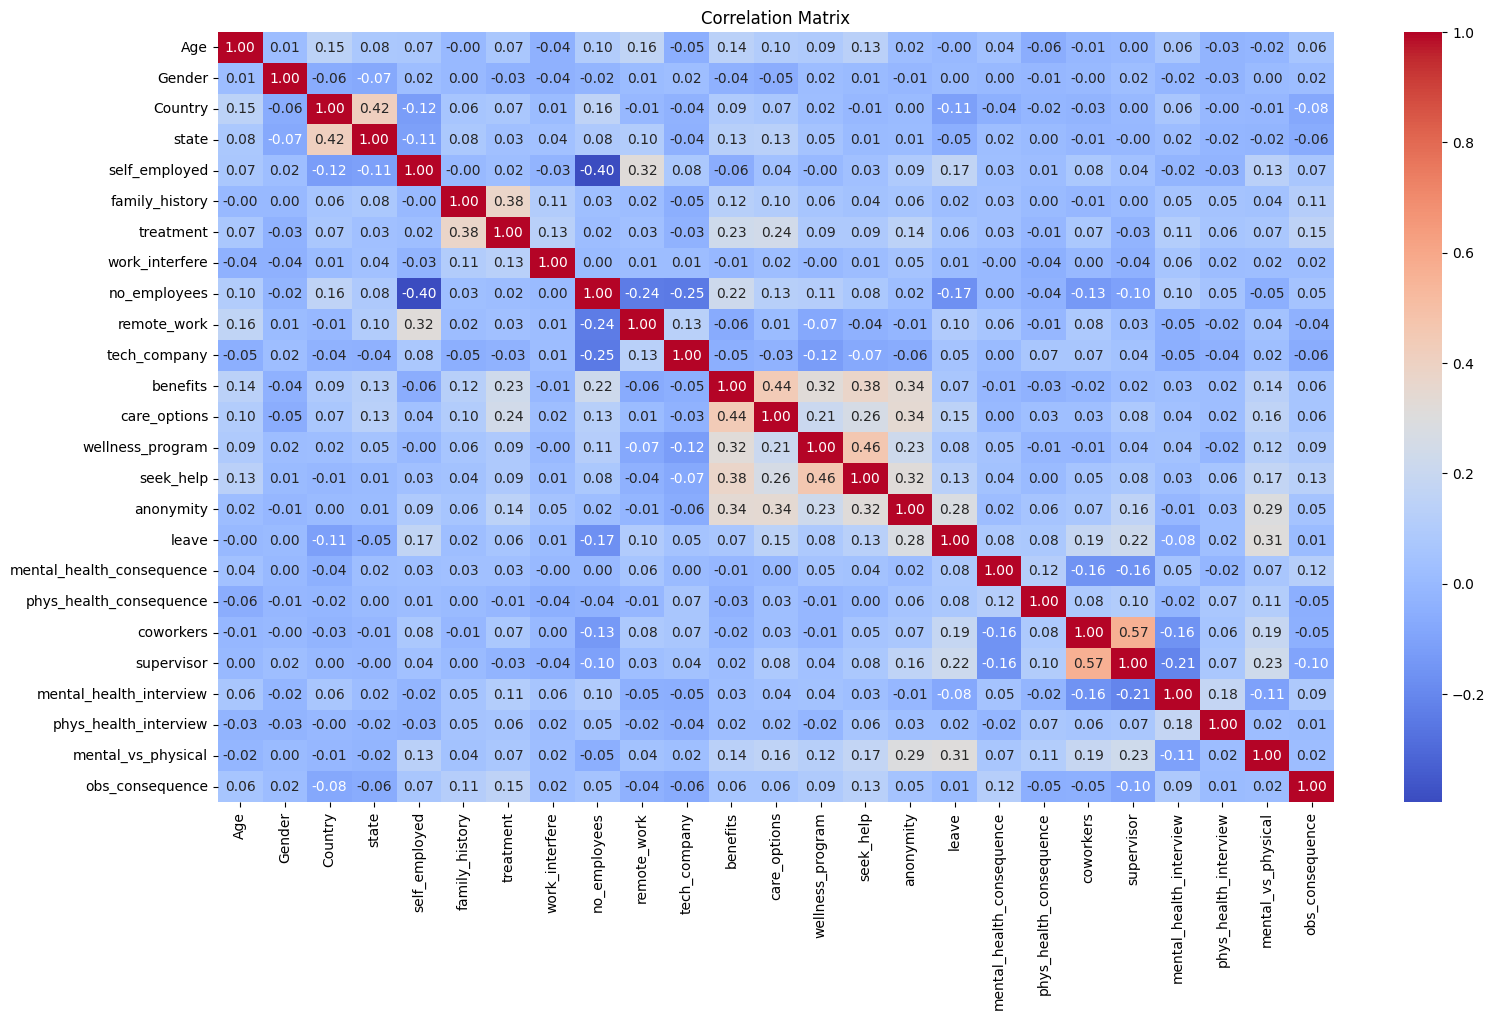

In [544]:
plt.figure(figsize=(18, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [545]:
X = df.drop(columns=['treatment'],axis=1)
Y = df['treatment']

In [546]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [547]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **LOGISTIC REGRESSION**

In [548]:
lr = LogisticRegression()
lr.fit(X_train_scaled,Y_train)

LogisticRegression()

In [549]:
Y_pred = lr.predict(X_test_scaled)
Y_pred

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0])

In [550]:
accuracy_score(Y_test,Y_pred)

0.7295081967213115

In [551]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72       119
           1       0.74      0.73      0.73       125

    accuracy                           0.73       244
   macro avg       0.73      0.73      0.73       244
weighted avg       0.73      0.73      0.73       244



In [552]:
print(confusion_matrix(Y_test,Y_pred))

[[87 32]
 [34 91]]


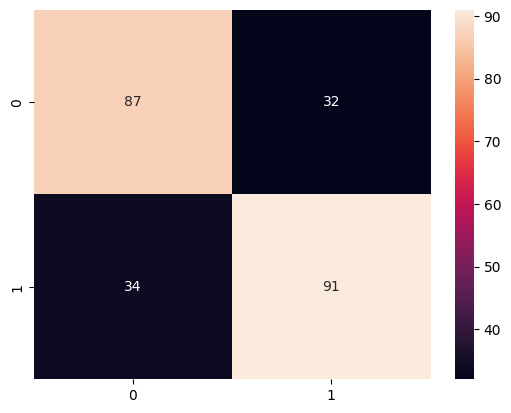

In [553]:
sns.heatmap(confusion_matrix(Y_test,Y_pred),annot=True,fmt='d')
plt.show()

# **RANDOM FOREST CLASSIFER USING GRIDSEARCH CV**

In [554]:
param_grid_rfc = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [555]:
grid_search_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rfc, cv=5, scoring='accuracy')
grid_search_rfc.fit(X_train_scaled, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [556]:
best_rfc = grid_search_rfc.best_estimator_
y_pred_rfc = best_rfc.predict(X_test_scaled)
accuracy_rfc = accuracy_score(Y_test, y_pred_rfc)
print(f"Best Random Forest Accuracy: {accuracy_rfc}")

Best Random Forest Accuracy: 0.7704918032786885


In [557]:
print(classification_report(Y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76       119
           1       0.76      0.80      0.78       125

    accuracy                           0.77       244
   macro avg       0.77      0.77      0.77       244
weighted avg       0.77      0.77      0.77       244



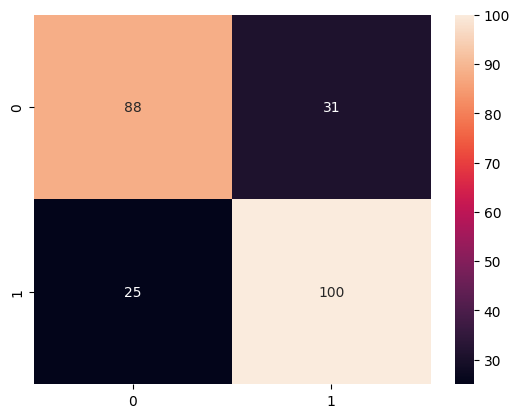

In [558]:
sns.heatmap(confusion_matrix(Y_test,y_pred_rfc),annot=True,fmt='d')
plt.show()

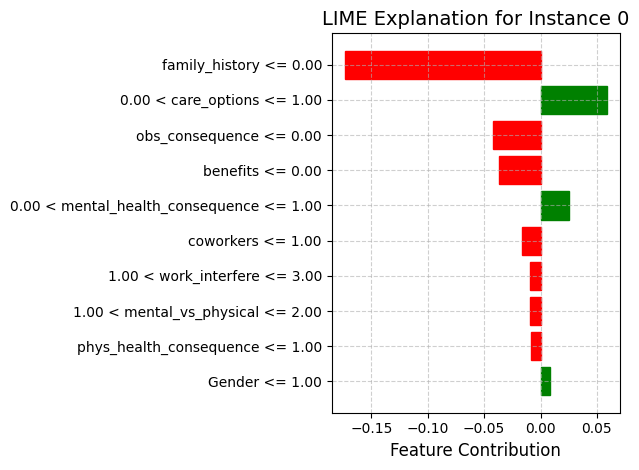

In [559]:
fig = explanation.as_pyplot_figure()
plt.title(f'LIME Explanation for Instance {idx}', fontsize=14)
plt.xlabel('Feature Contribution', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Customize bar colors and text
bars = plt.gca().patches
for bar in bars:
    if bar.get_width() > 0:
        bar.set_color('green')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()

In [560]:
y_pred_rfc_prob = best_rfc.predict_proba(X_test_scaled)[:,1] # Probabilities for class 1
roc_auc = roc_auc_score(Y_test, y_pred_rfc_prob)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.8354285714285714


In [561]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_rfc_prob)
roc_auc = auc(fpr, tpr)

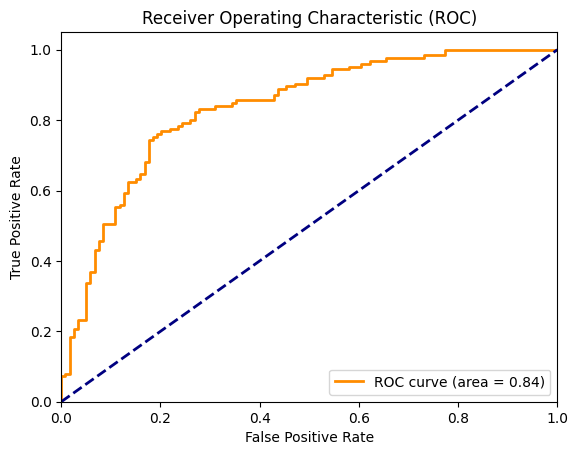

In [562]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# **DECISION TREE CLASSIFIER USING GRIDSEARCH CV**

In [563]:
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [564]:
grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train_scaled, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [565]:
best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test_scaled)
accuracy_dt = accuracy_score(Y_test, y_pred_dt)
print(f"Best Decision Tree Accuracy: {accuracy_dt}")

Best Decision Tree Accuracy: 0.7377049180327869


In [566]:
print(classification_report(Y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.70      0.80      0.75       119
           1       0.78      0.68      0.73       125

    accuracy                           0.74       244
   macro avg       0.74      0.74      0.74       244
weighted avg       0.74      0.74      0.74       244



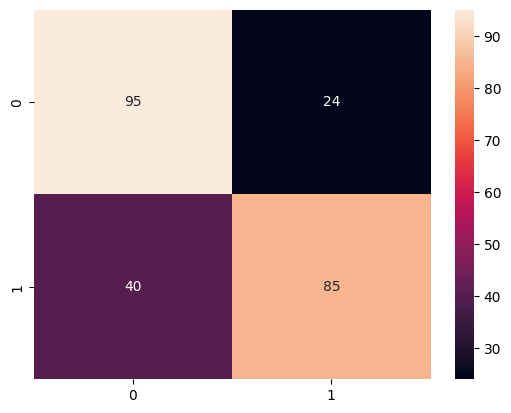

In [567]:
sns.heatmap(confusion_matrix(Y_test,y_pred_dt),annot=True,fmt='d')
plt.show()

# **GRADIENT BOOSTING CLASSIFIER**

In [568]:
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42) # Adjust n_estimators as needed
gbc.fit(X_train_scaled, Y_train)

GradientBoostingClassifier(random_state=42)

In [569]:
y_pred_gbc = gbc.predict(X_test_scaled)
accuracy_gbc = accuracy_score(Y_test, y_pred_gbc)
print(f"Best Gradient Boosting Accuracy: {accuracy_gbc}")

Best Gradient Boosting Accuracy: 0.7540983606557377


In [570]:
print(classification_report(Y_test, y_pred_gbc))

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       119
           1       0.76      0.77      0.76       125

    accuracy                           0.75       244
   macro avg       0.75      0.75      0.75       244
weighted avg       0.75      0.75      0.75       244



<Axes: >

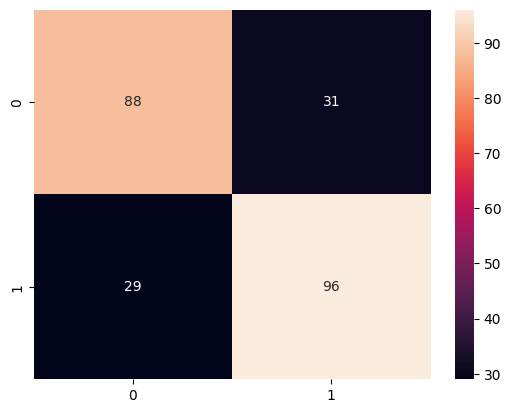

In [571]:
sns.heatmap(confusion_matrix(Y_test, y_pred_gbc), annot=True, fmt='d')

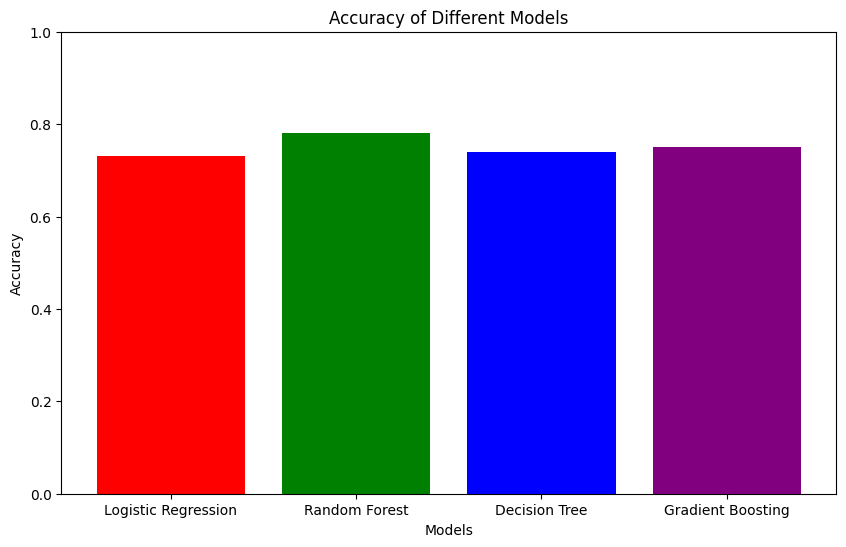

In [572]:
model_accuracies = {
    'Logistic Regression': 0.73,
    'Random Forest': 0.78,
    'Decision Tree': 0.74,
    'Gradient Boosting' : 0.75
}

models = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['red', 'green', 'blue','purple','orange'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy of Different Models")
plt.ylim(0, 1)
plt.show()

# **As we can see clearly the accuracy of Random forest classifier is higher than every other model so i am selecting Random Forest Classifier**

In [573]:
importances = best_rfc.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [574]:
top_features = feature_importance_df.head(10)

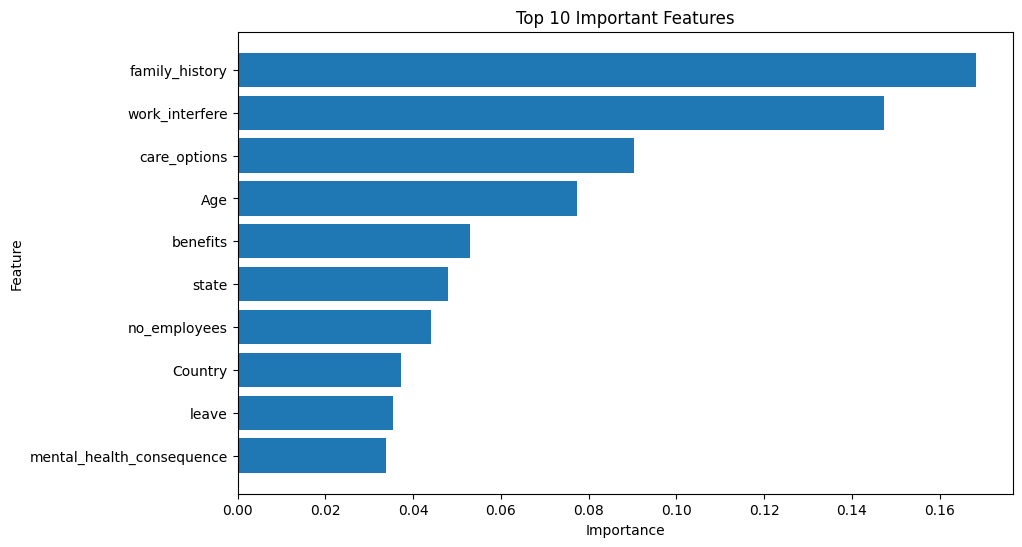

In [575]:
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Important Features")
plt.gca().invert_yaxis()
plt.show()

In [576]:
import pickle
with open('rfc_model.pkl', 'wb') as file:
    pickle.dump(best_rfc, file)